In [1]:
!date

Tue Nov  7 14:48:31 EST 2023


In [2]:
pwd

'/mmfs1/data/aglinska/BC-sim/Code'

In [3]:
%%time
print('importing')
import ants
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

importing


/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/data/aglinska/anaconda3/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


CPU times: user 1.91 s, sys: 627 ms, total: 2.53 s
Wall time: 45.4 s


In [4]:
def sphere(shape, radius, position):
    """Generate an n-dimensional spherical mask."""
    # assume shape and position have the same length and contain ints
    # the units are pixels / voxels (px for short)
    # radius is a int or float in px
    assert len(position) == len(shape)
    n = len(shape)
    semisizes = (radius,) * len(shape)

    # genereate the grid for the support points
    # centered at the position indicated by position
    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]
    # calculate the distance of all points from `position` center
    # scaled by the radius
    arr = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(position, semisizes):
        # this can be generalized for exponent != 2
        # in which case `(x_i / semisize)`
        # would become `np.abs(x_i / semisize)`
        arr += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below or equal to 1
    return arr <= 1.0

In [5]:
# linear
# nearestNeighbor
# multiLabel for label images #(deprecated, prefer genericLabel)
# gaussian
# bSpline
# cosineWindowedSinc
# welchWindowedSinc
# hammingWindowedSinc
# lanczosWindowedSinc
# genericLabel use this for label images

In [6]:
def do_selective_tx(temp,coords = (32,32,50),sz1=10,sz2=2,do_plot=True,tmp_dir='/scratch/bergerar/'):

    sphere_small = temp.new_image_like(sphere(shape=brain_size, radius=sz1, position=coords)*1.0)
    sphere_big = temp.new_image_like(sphere(shape=brain_size, radius=sz2, position=coords)*1.0)

    if do_plot==True:
        temp.plot_ortho(sphere_small*3+sphere_big*7,overlay_cmap='flag',xyz=coords,flat=True,overlay_alpha=.5,title='Deformation Targets')

    mytx = ants.registration(fixed=sphere_big, moving=sphere_small,mask=sphere_big+sphere_small,type_of_transform = 'SyNOnly',outprefix=tmp_dir) # learns a vector field from small to big sphere
    #warpedBrain = ants.apply_transforms(fixed=temp, moving=temp,transformlist=mytx['fwdtransforms'][0],interpolator='bSpline') # applies the transformation
    #warpedBrain = ants.apply_transforms(fixed=temp, moving=temp,transformlist=mytx['fwdtransforms'][0],interpolator='bSpline')
    warpedBrain = ants.apply_transforms(fixed=temp, moving=temp,transformlist=mytx['fwdtransforms'][0],interpolator='cosineWindowedSinc')
    #print(mytx['fwdtransforms'][0])
    #warpedBrain.plot_ortho(flat=True,xyz=coords)

    #mytx['warpedmovout'].plot_ortho(flat=True,xyz=coords)
    if do_plot==True:
        temp.plot_ortho_double(warpedBrain,xyz=coords,title='Before and After',title_dy=.22)
        (warpedBrain-temp).plot_ortho(flat=True,cmap='bwr',xyz=coords,title='Difference Map')
        
    #temp.plot_ortho((temp-warpedBrain)>np.sort((temp-warpedBrain).numpy().flatten())[-250],flat=True,overlay_alpha=.5,overlay_cmap='hot',xyz=coords)
    #temp.plot_ortho(warpedBrain-temp,flat=True,overlay_alpha=.5,overlay_cmap='bwr',xyz=coords)
    
    #J = ants.create_jacobian_determinant_image(domain_image=warpedBrain,tx=mytx['fwdtransforms'][0])
    #J = J-1
    #J[abs(J.numpy())<.25]=0
    #if do_plot==True:
    #    warpedBrain.plot_ortho(J,flat=True,overlay_alpha=.5,xyz=coords,title='Jacobian Map')
    
    return warpedBrain

In [7]:
brain_size = (64,64,64)

In [8]:
temp = ants.image_read('../Misc/Atlas_brain_2mm.nii')
temp = ants.resample_image(image=temp,resample_params=brain_size,use_voxels=True,interp_type=1)
temp = temp.iMath_normalize()
temp.max()

1.0

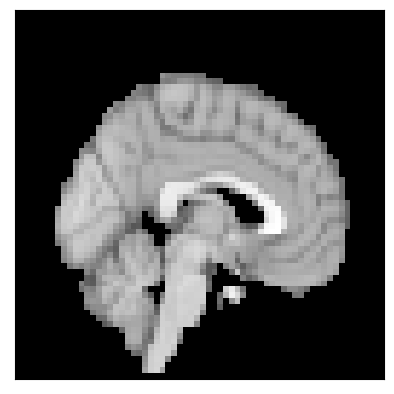

In [9]:
plt.imshow(np.rot90(temp.numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);

In [10]:
all_ims = []

In [11]:
td_spheres_2 = [17.5,22.5,27.5]
adhd_spheres_2 = [7,10,12]

In [12]:
# for r in tqdm(range(len(td_spheres_2))):
#     for c in range(len(adhd_spheres_2)):
#         td_sphere1 = 22.5
#         td_sphere2 = td_spheres_2[r]
#         TD_brain = do_selective_tx(temp,coords = (32,32,32),sz1=td_sphere1,sz2=td_sphere2,do_plot=False,tmp_dir='/scratch/aglinska/')
        
#         adhd_sphere1 = 10
#         adhd_sphere2 = adhd_spheres_2[c]
        
#         ADHD_brain = do_selective_tx(TD_brain,coords = (32,48,25),sz1=adhd_sphere1,sz2=adhd_sphere2,do_plot=False,tmp_dir='/scratch/aglinska/')
#         all_ims.append(ADHD_brain)


for c in range(len(adhd_spheres_2)):
    for r in tqdm(range(len(td_spheres_2))):
        td_sphere1 = 22.5
        td_sphere2 = td_spheres_2[r]
        TD_brain = do_selective_tx(temp,coords = (32,32,32),sz1=td_sphere1,sz2=td_sphere2,do_plot=False,tmp_dir='/scratch/aglinska/')
        
        adhd_sphere1 = 10
        adhd_sphere2 = adhd_spheres_2[c]
        
        ADHD_brain = do_selective_tx(TD_brain,coords = (32,48,25),sz1=adhd_sphere1,sz2=adhd_sphere2,do_plot=False,tmp_dir='/scratch/aglinska/')
        all_ims.append(ADHD_brain)

100%|█████████████████████████████████████| 3/3 [00:21<00:00,  7.05s/it]


In [13]:
nrows = len(td_spheres_2)
ncols = len(adhd_spheres_2)

In [14]:
pwd

'/mmfs1/data/aglinska/BC-sim/Code'

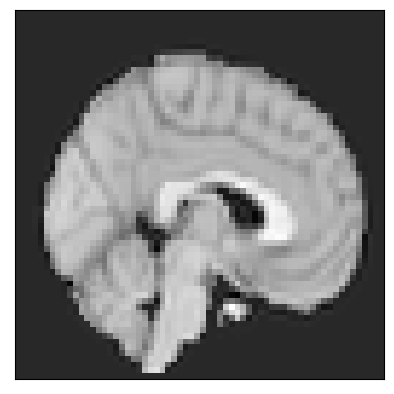

In [19]:
plt.close()
for i in range(len(all_ims)):
    ofn = f'../Figures/DataMatrix/{i}.png'
    plt.imshow(np.rot90(all_ims[i].numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);
    plt.savefig(ofn,transparent=True)

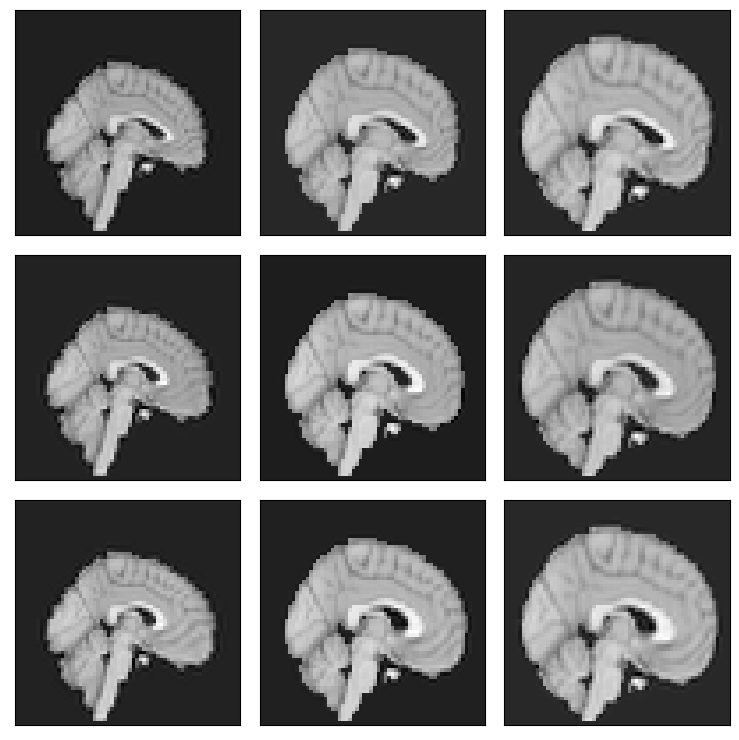

In [94]:
plt.figure(figsize=(7.5,7.5))
for i in range(int(nrows*ncols)):
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(np.rot90(all_ims[i].numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);
    ofn = f'../Figures/DataMatrix/{i}.png'

plt.tight_layout()

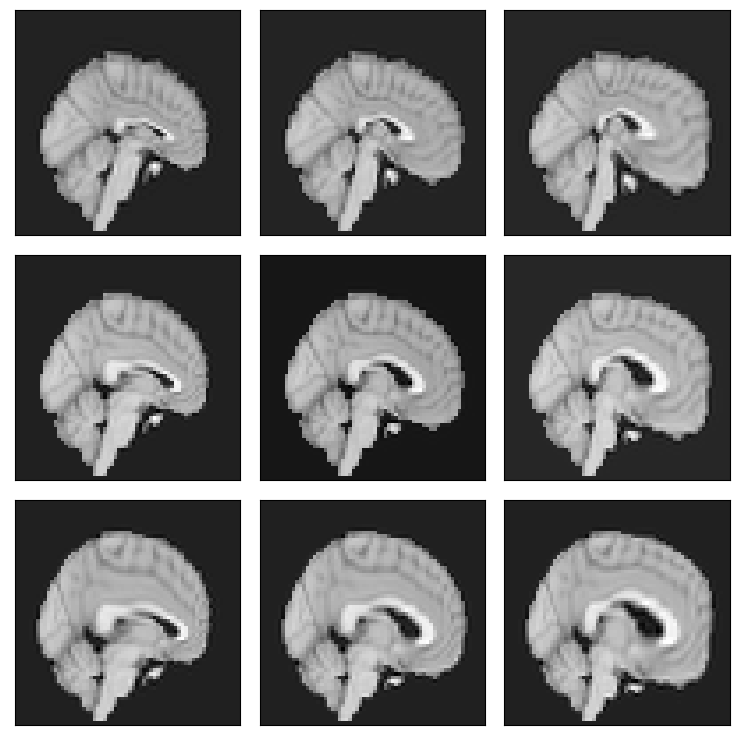

In [58]:
plt.figure(figsize=(7.5,7.5))
for i in range(int(nrows*ncols)):
    plt.subplot(nrows,ncols,i+1)
    plt.imshow(np.rot90(all_ims[i].numpy()[32,:,:]),cmap='gray');plt.xticks([]);plt.yticks([]);

plt.tight_layout()